# Welcome to the introduction to machine learning workshop!!!

This is a Python notebook for reference. Feel free to set this up on Google Colab (https://colab.research.google.com/), Kaggle Kernel (https://www.kaggle.com/barryxue/introduction-to-ml-workshop/edit) or your local machine with your favorite IDEs, and follow along with the presentation! 

All the datasets are available on a shared google drive (https://drive.google.com/drive/folders/1IAG4U91Y811WW-coUOg4upHNDveD4mfH?usp=sharing). The name of the datasets are listed. I suggest putting the dataset file under the same folder as your notebook for easy access. 

Once you have the dataset, run the cell below to read in the data and test out all the model demos. The markdown cells will explain what the codes are doing, but please ask questions if anything is unclear, or you run into issues. There are no stupid questions! 

## Categories of ML Tasks

Machine Learning tasks can be generalized into three categories. 

| Supervised | Unsupervised | Reinforcement |
| ---------- | ------------ | ------------- |
| A model is trained given the input features, X, and their corresponding targets, Y | A model is trained given only the input features, X, without their corresponding targets | Train a model or an action policy of an agent based on feedback from the environment | 
| regressions tasks, labeled classification tasks | clustering, dimensionality reduction |  markov decision process, Q table learning |


In this workshop, we will look at both supervised and unsupervised tasks, including: 
* Stock Price Prediction 
* Image Classification
* Anomaly Detection

There are no reinforcement learning tasks in this workshop, but it will be covered in future workshops, stay tuned! 😁

<b>At the end of this workshop, we will host a mini-competition using another image classification dataset. There will be prizes for top contenders!</b>

## Steps to solve a ML task

<h4>We follow the guideline of the "Machine Learning Life Cycle" when building our model.</h4>

<!-- ![ML-Lifecycle](ML-lifecycle.drawio.png){ width="800" height="600" style="display: block; margin: 0 auto" } -->
<p align="center">
    <img src="ML-lifecycle.drawio.png">
<p>

In reality, designing and implementing data pipeline and making model production-ready is a lot more time consuming than model building; we will cover these aspect of ML in other workshops in the future. 

However, in this workshop, we already collected the data for you, and there will not be any model deployment required. We will focus on the `training` and `evaluation` of a model. 


In [3]:
"""Use this cell to setup the packages"""
# if this has issue, uncomment the cell below
# !pip3 install -U scikit-learn
# !pip3 install torch torchvision torchaudio 
# !pip3 install pandas numpy seaborn matplotlib

'Use this cell to setup the packages'

## Stock Price Prediction

Algorithmic trading is an extremely popular field. Many of you probably heard of terms such as 'quantitative trading' or 'quantitative research' while looking for your next internship/job. `Quantitative Researchers/Traders` (quants for short) differ from traditional traders because they rely on algorithms, which are constructed based on models, to achieve trading objectives, such as high-frequency trading and arbitrage trading. 
<br>

To create effective trading strategies, a trader must leverage as much predictive power as possible. For the first example, we are attempting to model a stock's trend with ML, and see if this model is effective in predicting the future price. 
<br>

This is a special supervised regression task that uses time as a feature. Let's see how to solve this interesting problem! 

> Disclaimer: This is only a demonstration. The method introduced in this section is NOT financial advice, so please be cautious and seek professional advice. In addition, some tools might restrict their usage on for-profit applications, always read the terms and conditions before proceeding.  

### Data Collection 

Since we are only practicing model building for this workshop, we can download pre-made stock price data in CSV form. We will be using the stock history of Tata Beverages Limited from 2013 to 2018 as our target dataset. File name is `NSE-TATAGLOBAL11.csv`.

If you want to build a more ambitious model. There are many high-quality free API services you can get up-to-date data from. I have seen a lot of people use `Yahoo! Finance` (`yfiance`) for their projects. Here is their official documentation: https://pypi.org/project/yfinance/. 


         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-10-08  208.00  222.25  206.85  216.00  215.15             4642146.0   
1  2018-10-05  217.00  218.60  205.90  210.25  209.20             3519515.0   
2  2018-10-04  223.50  227.80  216.15  217.25  218.20             1728786.0   
3  2018-10-03  230.00  237.50  225.75  226.45  227.60             1708590.0   
4  2018-10-01  234.55  234.60  221.05  230.30  230.90             1534749.0   

   Turnover (Lacs)  
0         10062.83  
1          7407.06  
2          3815.79  
3          3960.27  
4          3486.05  


<AxesSubplot: ylabel='Close'>

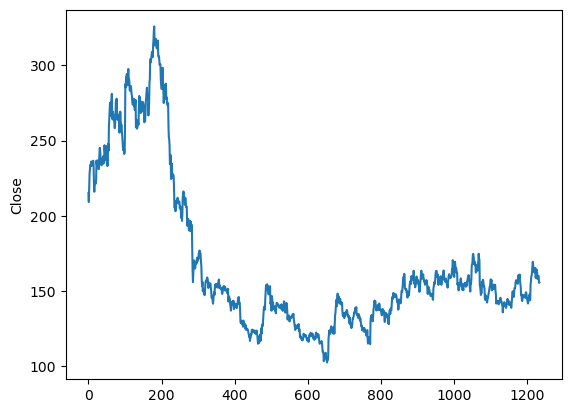

In [4]:
# load data 
import pandas as pd 
import seaborn as sns

stock_df = pd.read_csv('./NSE-TATAGLOBAL11.csv')
print(stock_df.head())

# visualize the data
sns.lineplot(data=stock_df['Close'])

In [5]:
# split data into train and test segments
print("total number of rows: ", stock_df.shape[0])
train_percentage = 0.7
stock_train = stock_df.iloc[:int(stock_df.shape[0]*train_percentage), :].Close.to_numpy()
stock_test = stock_df.iloc[int(stock_df.shape[0]*train_percentage):, :].Close.to_numpy()
print(f"Using {train_percentage*100}% of the data as training data, we have {stock_train.shape[0]} of training rows and {stock_test.shape[0]}  of testing rows.")

total number of rows:  1235
Using 70.0% of the data as training data, we have 864 of training rows and 371  of testing rows.


Unlike traditional regression problems, where we look at several feature distributions and correlations between features to create a model, time series prediction problems like this one only have one feature, time. 

Time as a feature is not very helpful at each individual timestamp. Knowing that it is `July 21, 2017, at 3:20 PM` will not help us find the stock price at this time. However, we know people make trading decisions based on events that happened recently, and existing stock prices can be decent reflections of the recent trend of trading. So if we know the stock price at `July 21, 2017, 3:20 PM`, we can probably guess the stock price at `July 21, 2017, 3:21 PM`. Thus, we can assume `local temporal dependency` and use this to make predictions. 

One approach to model this dependency is the `moving average filter`. Essentially, we average the values in a given time range close to the target timestamp, and use that as our prediction. 

Let's try this using the training dataset with different sizes. 

In [6]:
# create a moving average function 
import numpy as np 
def moving_avg(lst, size=50):
    """Moving Window Avg with a default window size of 50"""
    mov_avgs = []
    for i in range(size, len(lst)): 
        mov_avgs.append(sum(lst[i-size:i]) / size) 
    return mov_avgs

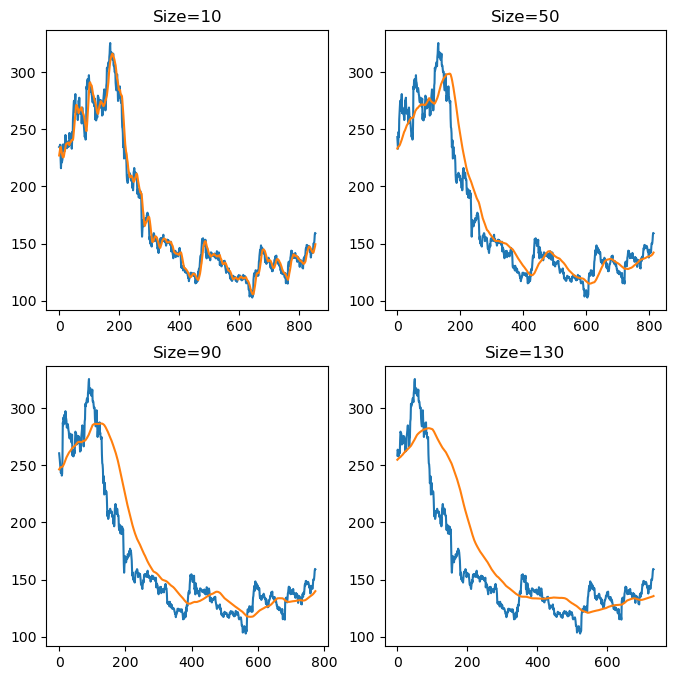

In [7]:
# visualize it against the original 
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,2, figsize=(8,8))

r,c = 0,0
for size in [10, 50, 90, 130]: 
    result = moving_avg(stock_train, size=size)
    axes[r,c].title.set_text(f'Size={size}')
    sns.lineplot(data=stock_train[size:], ax=axes[r,c])
    sns.lineplot(data=result, ax=axes[r,c])
    c+=1
    if c == 2: 
        r+=1
        c=0

The moving average method 'smoothens' the original, high-frequency curve.

From the graphs, we can also observe the effect of different window sizes. The smaller window generates a very similar curve to the original one, whereas the larger window size generates a way smoother approximation of the original.

There are advantages and disadvantages to large and small window sizes.

|              | Small                                                            | Large                                                                        |
| ------------ | ---------------------------------------------------------------- | ---------------------------------------------------------------------------- |
| Advantage    | More accurate approximation for points closer to existing values | More generalizable approximation for an unknown time further into the future |
| Disadvantage | Not predictive of future values                                  | Less accurate                                                                |


The `moving average` is our `baseline method`. A baseline is the bare minimum we establish before we run other models, and it is going to be the model we compare our new models against.

Let's try to improve on this baseline using a `recurrent neural network` (RNN) model. More specifically, we will attempt a special RNN model, `LSTM`. 

`LSTM` takes in prices at the previous time as the input features, and use those prices to predict the current value. We will construct the training and testing set using a window method, i.e. for each data point, we use the values in the recent window as its input feature. To keep the training time down, we will use a window of size 10. 

> More on RNN and LSTM: https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e. 

In [8]:
# normalize data
"""
We want to keep the values low, but maintain their ratios. 
Smaller input values will produce smaller weights, and this will make training and storing the model easier.  
"""
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler((0,1))
norm_stock_train = mms.fit_transform(stock_train.reshape(-1,1))

mms_test = MinMaxScaler((0,1))
norm_stock_test = mms_test.fit_transform(stock_test.reshape(-1, 1))

In [9]:
# construct the feature/target pair 
import torch

size = 10
X_train, y_train = [], []
X_test, y_test = [], []
for i in range(size, len(norm_stock_train)):
    # numpy indexing
    X_train.append(norm_stock_train[i-size:i, 0])
    y_train.append(norm_stock_train[i, 0])

for j in range(size, len(norm_stock_test)): 
    X_test.append(norm_stock_test[j-size:j, 0])
    y_test.append(norm_stock_test[j, 0])

# cast back into tensor 
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)



/var/folders/bd/3fcn_cld06z1y5f68_qm162m0000gn/T/ipykernel_41710/4036166291.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/torch/csrc/utils/tensor_new.cpp:233.)
  X_train = torch.Tensor(X_train)


To construct the `LSTM` model, we will be using PyTorch. 

All PyTorch network models consist of two components: the model class, and the training procedure. 

The model class will have a `__init__` method (like all python classes) and a `forward` method. `__init__` is where all the layers and utilities are initialized, and `forward` is where we define how the input is going to pass through the network. 

We define the optimization method and the loss function before training. The training process will be defined as a loop, where we will iteratively pass our input through the network model, and use the loss function and optimization method to update the model weights. 

In [10]:
# create model
import torch 
from torch import nn

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers*x.size(0), self.hidden_dim)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, :]) 
        return out

In [11]:
# training 
model = LSTM(input_dim=size, hidden_dim=10, output_dim=1, num_layers=2)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

import time
start_time = time.time()

model.train(True)
for t in range(100):
    train_prediction = []
    running_loss, counter = 0, 0
    for x, y in zip(X_train, y_train): 
        y_train_pred = model(x.reshape(1, -1))
        train_prediction.append(y_train_pred)
        loss = criterion(y_train_pred, y.reshape(1, -1))
        running_loss += loss.item()
        counter += 1
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print("Epoch ", t, "MSE: ", running_loss/counter)
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.0225774691442529
Epoch  1 MSE:  0.002606001264166905
Epoch  2 MSE:  0.002353875074118842
Epoch  3 MSE:  0.0023027560987618286
Epoch  4 MSE:  0.002318008889891916
Epoch  5 MSE:  0.0023506579456831897
Epoch  6 MSE:  0.0023742831855865345
Epoch  7 MSE:  0.0023731632401112635
Epoch  8 MSE:  0.002340894225657423
Epoch  9 MSE:  0.002277564071757448
Epoch  10 MSE:  0.002186995240342055
Epoch  11 MSE:  0.002075720362210716
Epoch  12 MSE:  0.0019526996540906998
Epoch  13 MSE:  0.0018292036416173176
Epoch  14 MSE:  0.001718470145499106
Epoch  15 MSE:  0.001631764593799072
Epoch  16 MSE:  0.0015655378469795408
Epoch  17 MSE:  0.001506622378054219
Epoch  18 MSE:  0.0014448811722820132
Epoch  19 MSE:  0.0013780022941468689
Epoch  20 MSE:  0.0013077424160587434
Epoch  21 MSE:  0.0012407398992117812
Epoch  22 MSE:  0.0011813513263134498
Epoch  23 MSE:  0.001133066804510908
Epoch  24 MSE:  0.0010966194825603925
Epoch  25 MSE:  0.0010702144442636
Epoch  26 MSE:  0.001052770866963643
Ep

In [12]:
# evaluation 
model.train(False)
test_predictions = []
running_loss, counter = 0, 0
for x, y in zip(X_test, y_test): 
    y_test_pred = model(x.reshape(1, -1))
    test_predictions.append(y_test_pred.detach().item())
    loss = criterion(y_train_pred, y.reshape(1, -1))
    running_loss += loss.item()
    counter += 1
    
print("MSE: ", running_loss/counter)

MSE:  0.0828820942486829


<AxesSubplot: >

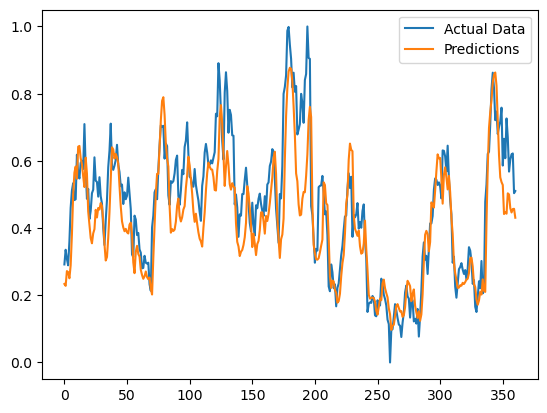

In [13]:
# visualize result 
sns.lineplot(data=y_test, label='Actual Data')
sns.lineplot(data=test_predictions, label='Predictions')

The final MSE, after several runs, hovers around 0.08-0.1. Keep in mind this is the normalized value (all values are between 0,1) so the loss value is not representative of the actual value (i.e. the is not how much money you are going to lose). 

> If you want to see the real error value, you can use the function, `MinMaxTransformer.inverse_transform()`, to get the original value back. 

Looking at the visualization, we can see with only 100 epochs of training, the LSTM model is able to correctly predict the trend of the price change. This shows that this isn't a bad model. 

## Image Classification 

Image classification is usually the first thing people think of when taking about computer vision, and we can see image classification model at work on a daily basis. For the second example, we will construct an effective image classification model to identify hand written digits from their picture. 

We will be looking at a support vector classifier, and then a simple Convolution Neural Network. 

Source: https://gist.github.com/xmfbit/b27cdbff68870418bdb8cefa86a2d558

In [14]:
# load data 
from torchvision.datasets import MNIST
from torchvision import transforms

# apply normalization to the image values 
tran = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
mnist_train = MNIST(root='./MNIST', train=True, download=True, transform=tran)
mnist_test = MNIST(root='./MNIST', train=False, download=True, transform=tran)

In [15]:
# description of the data
print("Prediction classes: ", str(mnist_train.classes))
print("Dimension of each images: ", mnist_train.data[0].shape)

print("Total training data size: ", len(mnist_train.data))
print("Total testing data size: ", len(mnist_test.data))

Prediction classes:  ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Dimension of each images:  torch.Size([28, 28])
Total training data size:  60000
Total testing data size:  10000


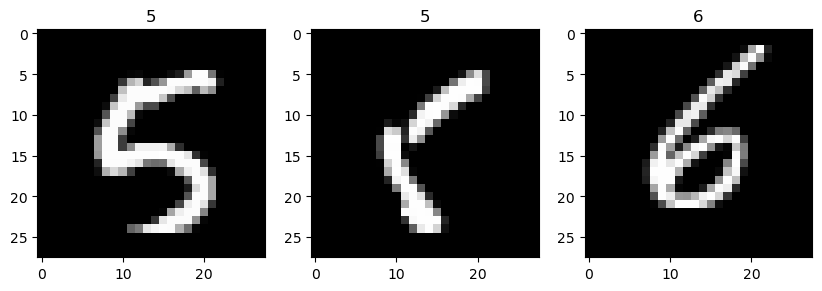

In [16]:
# visualize some pictures
import matplotlib.pyplot as plt 
import numpy as np

fig, axes = plt.subplots(1,3,figsize=(10,10))
for i in range(3): 
    ind = np.random.randint(len(mnist_train.data))
    axes[i].set_title(mnist_train.targets[ind].item())
    axes[i].imshow(mnist_train.data[ind], cmap='gray')

Quick Note: 

The tool we are using is called `torchvision`, it is PyTorch's Computer Vision library. The `MNIST` function returns the digits dataset as a PyTorch `Dataset` object, and it has several parameter we care about:
 
* classes: return the set of prediction classes 
* data: return the image data 
* targets: return the label for each images

Reasons to use PyTorch's Dataset: 

* When the dataset gets big, they are FAST!
* It makes pipelining from CPU memory, GPU memory, and disk storage easier. 
* Allow user to apply pre-existing transformation (not only limited to computer vision) in a modular fashion. 
* Sometimes you just have to :/ because you have to make you code standardized for other developers. 

Reasons NOT to use PyTorch's Dataset: 

* When data size is small (<10000), it actually can be slower than conventional data loading (dataframe, vanilla numpy array, etc). 
* When there is no GPU utilization available. 
* It can take quite a while to set up a custom dataset object! 

Once we created the `Dataset`, we want to pass it into a `Dataloader` to enable fast loading during training/testing. 

In [17]:
# put dataset into a dataloader 
import torch 

batch_size = 64
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_train,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_test,
                batch_size=batch_size,
                shuffle=False)

Now, we can start playing around with models. 

For SVM, we are using sklearn's SVC, which allows for different types of kernel transformation. Let's try both the `linear` and the `Gaussian` kernel 

In [18]:
# SVM model
from sklearn.svm import SVC

# let's try the linear kernel and the rbf (Gaussian) kernel 
SVM_linear = SVC(kernel='linear')
SVM_rbf = SVC(kernel='rbf')

# train the models (might take a while, so let's cut the training size to 2000)
SVM_linear.fit(mnist_train.data.reshape(len(mnist_train.data), -1)[:2000], mnist_train.targets[:2000])
SVM_rbf.fit(mnist_train.data.reshape(len(mnist_train.data), -1)[:2000], mnist_train.targets[:2000])

SVC()

In [20]:
# check the accuracy 
from sklearn.metrics import accuracy_score

linear_pred = SVM_linear.predict(mnist_test.data.reshape(len(mnist_test.data), -1))
rbf_pred = SVM_rbf.predict(mnist_test.data.reshape(len(mnist_test.data), -1))

print("Linear Accuracy: ", accuracy_score(mnist_test.targets, linear_pred))
print("Gaussian Accuracy: ", accuracy_score(mnist_test.targets, rbf_pred))

Linear Accuracy:  0.8916
Gaussian Accuracy:  0.9302


<b>SVMs are Pretty Good!! </b>

Now, let's try a more popular model, `convolutional neural network` (CNN). 

If you are unfamiliar with a neural network, just think of it as a collection of smaller linear models connected by some non-linear function (we call them activation functions). 

The CNN is just a NN with convolution operation filters as one or more hidden layers. The convolution operation is an aggregation function that adds/averages all the nearby pixel values into one value. This way the model can combine different convolution operations to create new image features. 

For image classification, this is actually very intuitive. Here's an analogy: 

* When you see a chair, you would recognize it as a chair because you see: 4 legs, 1 horizontal flat surface, and 1 vertical flat surface, and they are all arranged in a specific manner. 

These 'features' are all small patches from the images of other chairs you have seen previously in your experience. You then have to arrange these 'features' in a specific manner to match what you see now to know this is a chair. 

#### For this example: 

For this example, we have a CNN with 2 convolution layers, and 2 fully connected linear layers. 

When you are initializing a PyTorch convolution layer, you need to specify: 
* `in_channel`: The number of channel coming into the layer; if your input layer is a conv. layer (1st layer in the network is Conv2d), this should match the color channel of your image; black-n-white image have 1 channel and colored RGB images have 3 channels). 
* `out_channel`: The number of channel you want the output to have. More channels means larger output with more depth. You next Conv2d layer's `in_channel` should match the `out_channel`.
* `stride`: This specifies how big of a step the conv filter will move on the image. 
* `padding`: This specifies the size of zero padding on the side of the image.

When you are initializing a PyTorch linear layer, you need to specify: 
* `in_features`: Size of the input. If it is connected to a conv layer, we have to calculate how big the output will be once it gets flattened. 
* `out_features`: Desired size of the output. Same as the conv layer, the next layer's `in_features` should match the previous layer's `out_features`. 

In [21]:
# network models 
from torch import nn 
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=4*4*50, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # relu is a nonlinear activation function, every NN should have nonlinear activation functions
        x = F.max_pool2d(x, 2, 2) # maxpooling aggregates values together without convolution, the goal is to clear up unwanted noise by adding neighboring values together
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50) # this will flatten the precious output for the linear layers 
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x)) 
        return x

In [22]:
from torch import optim

# setup training parameters 
epochs = 10
use_cuda = False # turn this on if you have a GPU
model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # stochastic gradient descent 
criterion = nn.CrossEntropyLoss()
if use_cuda: 
    model = model.cuda()

# training loop (take 3.5 min on a macbook)
model.train(True)
for epoch in range(epochs):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        # x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))

/var/folders/bd/3fcn_cld06z1y5f68_qm162m0000gn/T/ipykernel_41710/1613805976.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


==>>> epoch: 0, batch index: 100, train loss: 2.300494
==>>> epoch: 0, batch index: 200, train loss: 2.296248
==>>> epoch: 0, batch index: 300, train loss: 2.283495
==>>> epoch: 0, batch index: 400, train loss: 2.038384
==>>> epoch: 0, batch index: 500, train loss: 1.702035
==>>> epoch: 0, batch index: 600, train loss: 1.648115
==>>> epoch: 0, batch index: 700, train loss: 1.575729
==>>> epoch: 0, batch index: 800, train loss: 1.556830
==>>> epoch: 0, batch index: 900, train loss: 1.543445
==>>> epoch: 0, batch index: 938, train loss: 1.539700
==>>> epoch: 1, batch index: 100, train loss: 1.529924
==>>> epoch: 1, batch index: 200, train loss: 1.528022
==>>> epoch: 1, batch index: 300, train loss: 1.517500
==>>> epoch: 1, batch index: 400, train loss: 1.525724
==>>> epoch: 1, batch index: 500, train loss: 1.513578
==>>> epoch: 1, batch index: 600, train loss: 1.511128
==>>> epoch: 1, batch index: 700, train loss: 1.500890
==>>> epoch: 1, batch index: 800, train loss: 1.506480
==>>> epoc

In [23]:
# testing
model.train(False)
for epoch in range(epochs): 
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        ave_loss = ave_loss * 0.9 + loss.item()* 0.1
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))

/var/folders/bd/3fcn_cld06z1y5f68_qm162m0000gn/T/ipykernel_41710/1613805976.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


==>>> epoch: 0, batch index: 100, test loss: 1.471962, acc: 0.984
==>>> epoch: 0, batch index: 157, test loss: 1.476789, acc: 0.987
==>>> epoch: 1, batch index: 100, test loss: 1.471962, acc: 0.984
==>>> epoch: 1, batch index: 157, test loss: 1.476789, acc: 0.987
==>>> epoch: 2, batch index: 100, test loss: 1.471962, acc: 0.984
==>>> epoch: 2, batch index: 157, test loss: 1.476789, acc: 0.987
==>>> epoch: 3, batch index: 100, test loss: 1.471962, acc: 0.984
==>>> epoch: 3, batch index: 157, test loss: 1.476789, acc: 0.987
==>>> epoch: 4, batch index: 100, test loss: 1.471962, acc: 0.984
==>>> epoch: 4, batch index: 157, test loss: 1.476789, acc: 0.987
==>>> epoch: 5, batch index: 100, test loss: 1.471962, acc: 0.984
==>>> epoch: 5, batch index: 157, test loss: 1.476789, acc: 0.987
==>>> epoch: 6, batch index: 100, test loss: 1.471962, acc: 0.984
==>>> epoch: 6, batch index: 157, test loss: 1.476789, acc: 0.987
==>>> epoch: 7, batch index: 100, test loss: 1.471962, acc: 0.984
==>>> epoc

<b>We end up with 0.991 testing accuracy!!!</b> 

So why does CNN work so well? 

* <b>Mathematically</b>, we don't really know :/, neural network produce a very nasty looking decision function, so it's hard to study it's gradient and figure out why model would work on a theoretical level. (However, there are some study on this matter.)
* <b>Intuitively</b>, think about the human visual understanding analogy mentioned before. The CNN model mimics, not all, but a good amount of properties of the human vision, and it seems that really helped. 

#### `Shameless self-plug`: There will be a workshop dedicated specifically for CNNs and computer vision models next quarter. Keep you eyes peeled for the date, and invite your friends!!!

## Housing Price Anomaly Detection

Anomaly Detection is a big word to encapsulate quite a diverse set of tasks. Depending on what the problem of interest is, the model architecture can be extremely complex, and it most likely will involve many subfield of machine learning (ex: computer vision, natural language, etc). 

Some examples: 

1. Trend anomaly: Price trend, lifestyle trends, etc. 
2. Image/Video anomaly: Corrupt images, unusual behavior on CCTV (you would be surprised how well this works).
3. Language anomaly: Profanity detection, natural language detection.

We will focus on finding the trend anomaly in boston housing price. More specifically, we will use a unsupervised cluster model with heuristics to categorize anomaly points. 

Download the `TimeSeriesExpedia.csv` file for this example, and put it in the root folder. 

There is another great case study for spotify, but unfortunately, there is no readily available dataset online (API access is needed). Feel free to look at the article, the writer included a lot of visualization and analysis.
The Spotify Example: https://towardsdatascience.com/unsupervised-anomaly-detection-on-spotify-data-k-means-vs-local-outlier-factor-f96ae783d7a7


In [24]:
# source: https://neptune.ai/blog/anomaly-detection-in-time-series

# load data
import pandas 
from sklearn.cluster import KMeans

df = pd.read_csv('TimeSeriesExpedia.csv')
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
data.head()

,price_usd,srch_booking_window,srch_saturday_night_bool
0,69.87,25,0
1,97.49,44,1
2,206.00,99,1
3,127.71,227,0
4,186.00,6,0


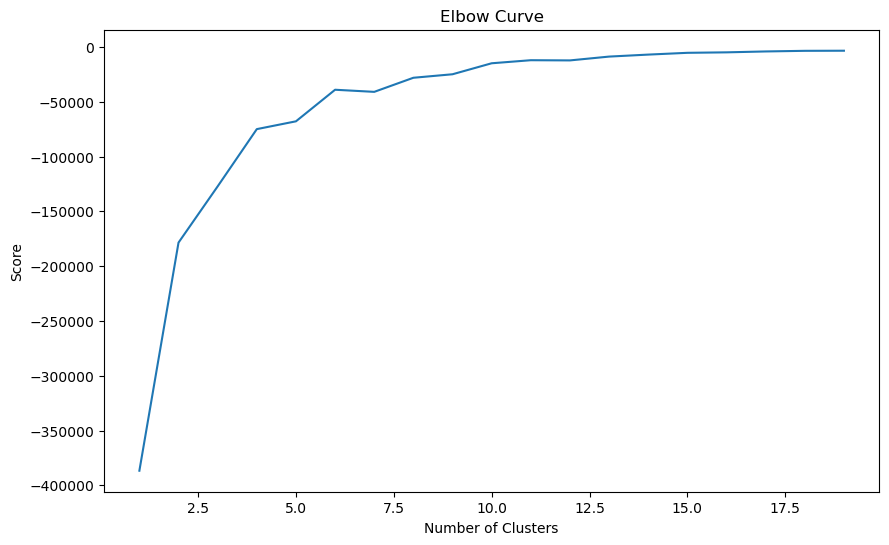

In [25]:
# find best kmeans parameters: number of clusters
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i, n_init='auto').fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

# visualize the elbow curve 
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

The purpose of the elbow curve is to find the sweet spot between clusters that are "not specific enough" and "overfitting on singular data points". 

Intuition: The most of amount of clusters you can have is the same as the total number of data points in the dataset. 
* once you set the number of clusters high enough, each cluster is only representative of one or two data points; when this happens, the model is no longer generalizable. 
* so we want to find the 'elbow' point of the # of cluster vs score curve. 

Here let's go with 10. 

In [26]:
# data transformation 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# apply PCA to reduce the dimension of each data point to 2 
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# standardize these 2 new features
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [27]:
# retrain the cluster and assign cluster to each data point
kmeans = [KMeans(n_clusters=i, n_init='auto').fit(data) for i in n_cluster]
df['cluster'] = kmeans[10].predict(data)
df.index = data.index
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts() # returns the size of each cluster 

8     16
0     10
4      8
5      7
3      3
2      3
1      3
6      1
7      1
9      1
10     1
Name: cluster, dtype: int64

We use a distance based heuristic to identify the anomaly. If a data points is too far away from its centroid, then we identify it as an anomaly. Here we use a threshold to classify the anomaly points. 

In [28]:
# get the distance of each point to their cluster center 

import numpy as np

# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i]=np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.1

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans[10])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

/var/folders/bd/3fcn_cld06z1y5f68_qm162m0000gn/T/ipykernel_41710/2815734910.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


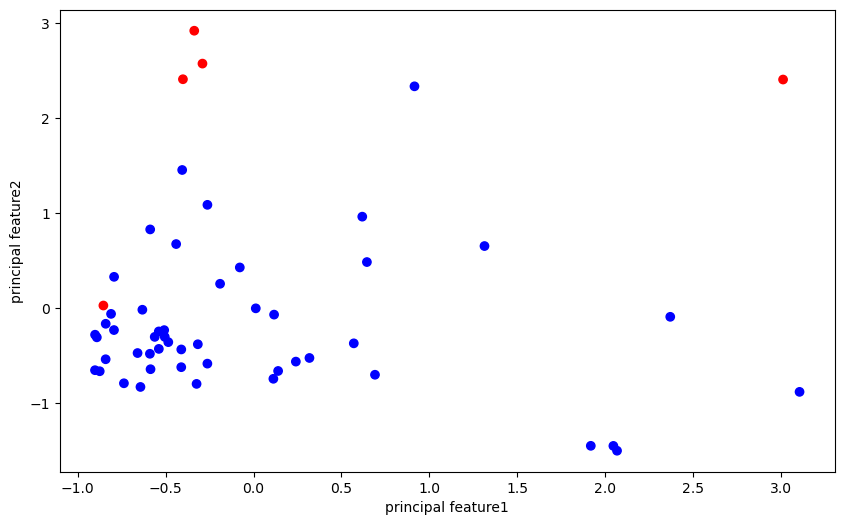

In [29]:
# visualize the points by principal features 
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

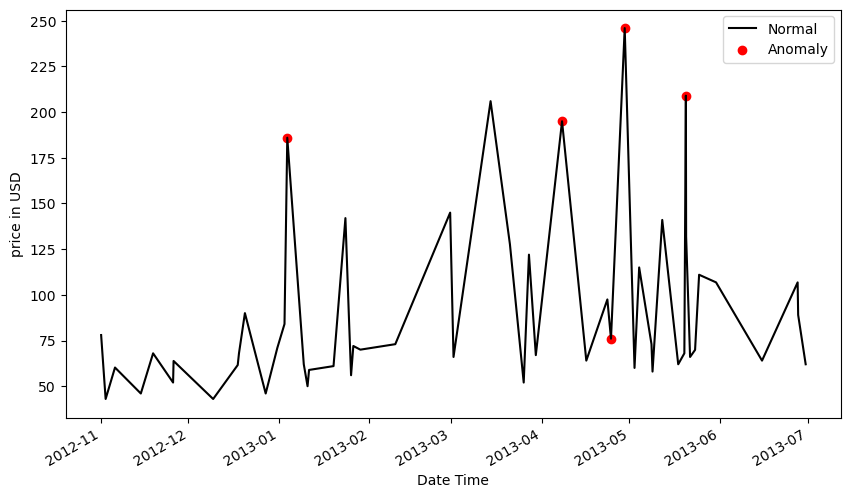

In [30]:
# visualize anomaly with time and actual price

df = df.sort_values('date_time')
#df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))
a = df.loc[df['anomaly1'] == 1, ['date_time', 'price_usd']] #anomaly


ax.plot(pd.to_datetime(df['date_time']), df['price_usd'], color='k',label='Normal')
ax.scatter(pd.to_datetime(a['date_time']),a['price_usd'], color='red', label='Anomaly')
ax.xaxis_date()
plt.xlabel('Date Time')
plt.ylabel('price in USD')
plt.legend()
fig.autofmt_xdate()
plt.show()

## Exercise: Cat or Dog? Image Binary Classification

You will revisit the image classification task, but now you will classify images as cat or dog. 

First, download the `cat-n-dog.zip` file from google drive, and unzip it at your root directory. 

I have already setup the data import as a PyTorch Dataloader object, so you can just follow the code for MNIST handwritten digits classification to train and evaluate your model. 

<b>Tip#1:</b> Start with the ConvNet I provided, then add/remove layers, change parameters, change training optimizer, and etc to improve accuracy.

<b>Tip#2:</b> The images are colored, so the input channel should be 3!

<b>Tip#3:</b> If you want to go above and beyond, go read up on the torchvision documentation. There are some already available CNN models out there ready to be used(ResNet, AlexNet, etc). You just have to re-train them with the cat and dog data. 
* Example to use pre-trained models: https://pytorch.org/vision/stable/models.html. 
* A list of available models: https://pytorch.org/vision/0.8/models.html.

The model with the highest accuracy will be the winner! <b>And there is a special prize for the winner!</b> Have Fun!!!

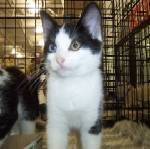

In [31]:
# don't change this!!
# load packages and check out the images
import torch 
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets,models
import torch.nn as nn
import torch.nn.functional as F
import PIL.Image as Image
from sklearn.model_selection import train_test_split

im=Image.open('./cat-n-dog/training_set/cats/cat.1000.jpg')
im

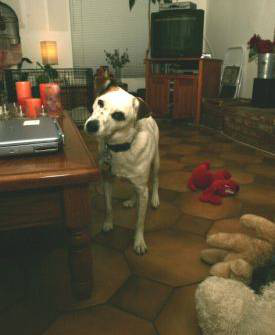

In [32]:
im2=Image.open('./cat-n-dog/training_set/dogs/dog.1016.jpg')
im2

torch.Size([1, 3, 224, 224])


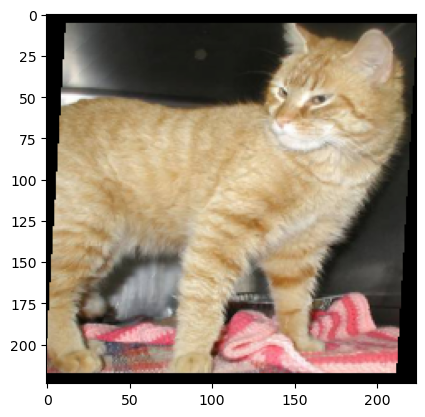

In [33]:
# don't change this!!
# create transformation (normalization, cropping, centering)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

# define input path
input_path='./cat-n-dog'
data_image={
    'train': datasets.ImageFolder(input_path+'/training_set', data_transforms['train'])
    , 'test':datasets.ImageFolder(input_path+'/test_set',data_transforms['test'])    
}

# create loaders
train_loader=torch.utils.data.DataLoader(data_image['train'],
                                batch_size=1,
                                shuffle=True,
                                num_workers=0)
test_loader=torch.utils.data.DataLoader(data_image['test'],
                                batch_size=1,
                                shuffle=True,
                                num_workers=0)

# check images
def denormalize_tonumpy(image): 
    image = image[0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

trainimages, trainlabels = next(iter(train_loader))
plt.imshow(denormalize_tonumpy(trainimages))
print(trainimages.size())

In [34]:
# don't change this!!!
# reset loaders
train_loader=torch.utils.data.DataLoader(data_image['train'],
                                batch_size=1,
                                shuffle=True,
                                num_workers=0)
test_loader=torch.utils.data.DataLoader(data_image['test'],
                                batch_size=1,
                                shuffle=True,
                                num_workers=0)

#### The baseline from earlier

In [35]:
# network models (feel free to change this)
from torch import nn 
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=140450, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=2)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x)) # relu is a nonlinear activation function, every NN should have nonlinear activation functions
        x = F.max_pool2d(x, 2, 2) # maxpooling aggregates values together without convolution, the goal is to clear up unwanted noise by adding neighboring values together
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.flat(x) # this will flatten the precious output for the linear layers 
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x)) 
        return x

In [36]:
# setup training parameters 
epochs = 10 # start low 
use_cuda = False # turn this on if you have a GPU
use_mps = True # turn this on if you are on m1 mac 
model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
if use_cuda: 
    model = model.cuda()
if use_mps: 
    model = model.to('mps')


# training loop (take 3.5 min on a macbook)
model.train(True)
for epoch in range(epochs):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        if use_mps: 
            x, target = x.to('mps'), target.to('mps')
        out = model(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))

# testing
model.train(False)
for epoch in range(epochs): 
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        if use_mps: 
            x, target = x.to('mps'), target.to('mps')
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        ave_loss = ave_loss * 0.9 + loss.item()* 0.1
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt * 1.0 / total_cnt))

/var/folders/bd/3fcn_cld06z1y5f68_qm162m0000gn/T/ipykernel_41710/3099043401.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


==>>> epoch: 0, batch index: 100, train loss: 0.700350
==>>> epoch: 0, batch index: 200, train loss: 0.702028
==>>> epoch: 0, batch index: 300, train loss: 0.698001
==>>> epoch: 0, batch index: 400, train loss: 0.692822
==>>> epoch: 0, batch index: 500, train loss: 0.705885
==>>> epoch: 0, batch index: 600, train loss: 0.685251
==>>> epoch: 0, batch index: 700, train loss: 0.870733
==>>> epoch: 0, batch index: 800, train loss: 0.760455
==>>> epoch: 0, batch index: 900, train loss: 0.767796
==>>> epoch: 0, batch index: 1000, train loss: 0.882086
==>>> epoch: 0, batch index: 1100, train loss: 0.636928
==>>> epoch: 0, batch index: 1200, train loss: 0.937197
==>>> epoch: 0, batch index: 1300, train loss: 0.809911
==>>> epoch: 0, batch index: 1400, train loss: 0.822645
==>>> epoch: 0, batch index: 1500, train loss: 0.719231
==>>> epoch: 0, batch index: 1600, train loss: 0.697792
==>>> epoch: 0, batch index: 1700, train loss: 0.680991
==>>> epoch: 0, batch index: 1800, train loss: 0.701929
=

KeyboardInterrupt: 